In [1]:
import os
os.chdir(os.path.dirname(INSERT_PATH_HERE))

In [2]:
!echo %path%

C:\ProgramData\Anaconda3;C:\ProgramData\Anaconda3\Library\mingw-w64\bin;C:\ProgramData\Anaconda3\Library\usr\bin;C:\ProgramData\Anaconda3\Library\bin;C:\ProgramData\Anaconda3\Scripts;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Windows\System32\OpenSSH\;C:\Program Files\Git\cmd;C:\Program Files\Calibre2\;C:\Users\Heiko\AppData\Local\Microsoft\WindowsApps;C:\Users\Heiko\AppData\Local\GitHubDesktop\bin;C:\Program Files\Protege\jre\bin;


In [3]:
file_to_embed = "./artists_graph.nt"

In [4]:
# Do the actual embedding
!java -jar jrdf2vec.jar -graph $file_to_embed -dimension 50 -numberOfWalks 500 -walkGenerationMode EXPERIMENTAL_NODE_WALKS_DUPLICATE_FREE

Using server port: 1808
Using 4 threads for walk generation and training.
Using vector dimension: 50
Using depth 4
Generating 500 walks per entity.
RDF2Vec Classic
05 Apr 2023 13:23:43  WARN [main] (RDF2Vec.java:322) - walkDirectory is not a directory. Using default.
05 Apr 2023 13:23:43  INFO [main] (WalkGeneratorManager.java:64) - Using NxParser.
05 Apr 2023 13:23:43  INFO [main] (WalkGeneratorManager.java:99) - Model read into memory.
05 Apr 2023 13:23:44  INFO [pool-1-thread-1] (WalkGenerationManager.java:426) - TOTAL PROCESSED ENTITIES: 1000
05 Apr 2023 13:23:44  INFO [pool-1-thread-1] (WalkGenerationManager.java:427) - TOTAL NUMBER OF PATHS : 66985
05 Apr 2023 13:23:44  INFO [main] (RDF2Vec.java:205) - Walks successfully generated. Starting training now...
05 Apr 2023 13:23:44 DEBUG [main] (RequestAddCookies.java:123) - CookieSpec selected: default
05 Apr 2023 13:23:44 DEBUG [main] (RequestAuthCache.java:77) - Auth cache not set in the context
05 Apr 2023 13:23:44 DEBUG [main] (P

In [5]:
from gensim.models import KeyedVectors

kv_file = "./walks/model.kv"
word_vectors = KeyedVectors.load(kv_file, mmap='r')

In [6]:
# Load ground truth
import pandas as pd
df = pd.read_csv ('bands_labels.csv',sep="\t")
dfX = df[['Band']]
dfY = df[['Genre']]

entities =list(dict.fromkeys(df['Band'].to_list()))
print(len(entities))

# load embeddings for entities in gold standard
embeddings = []
for e in entities:
    embeddings.append(word_vectors[e])

200


In [7]:
# evaluate in 10-fold CV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
dfX = pd.DataFrame(list(map(np.ravel, embeddings)))
clf = MLPClassifier(max_iter=10000)
scores = cross_val_score(clf, dfX, dfY.values.ravel(), cv=10)
scores.mean()

0.635

In [8]:
scores.std()

0.08381527307120104

In [9]:
# Create new ground truth for visualization by classes
# Targets: artists, record labels, cities
# get all papers from the graph
from rdflib import Graph, RDF, URIRef
import re

g = Graph()
g.parse('./artists_graph.nt')

lst_entities = []
lst_Y = []

regexp = re.compile('^http://dbpedia.org/resource/[0-9a-zA-Z_()]+$',re.ASCII)

artist_entities = set()
for e in g.subjects(RDF.type,URIRef("http://dbpedia.org/ontology/Artist")):
        s = e.toPython()
        if regexp.match(s):
            artist_entities.add(s)

for e in artist_entities:
    lst_entities.append(e)
    lst_Y.append("artist")
    
# print(lst_artist_entities)

labels_entities = set()
for e in g.subjects(RDF.type,URIRef("http://dbpedia.org/ontology/RecordLabel")):
        s = e.toPython()
        if regexp.match(s):
            labels_entities.add(s)

lst_labels_entities = []
for e in labels_entities:
    lst_entities.append(e)
    lst_Y.append("label")
    
cities_entities = set()
for e in g.subjects(RDF.type,URIRef("http://dbpedia.org/ontology/City")):
        s = e.toPython()
        if regexp.match(s):
            cities_entities.add(s)

lst_cities_entities = []
for e in cities_entities:
    lst_entities.append(e)
    lst_Y.append("city")
    
embeddings = []
for e in lst_entities:
    embeddings.append(word_vectors[e])

dfX = pd.DataFrame(list(map(np.ravel, embeddings)))
dfY = pd.DataFrame (lst_Y, columns = ['class'])

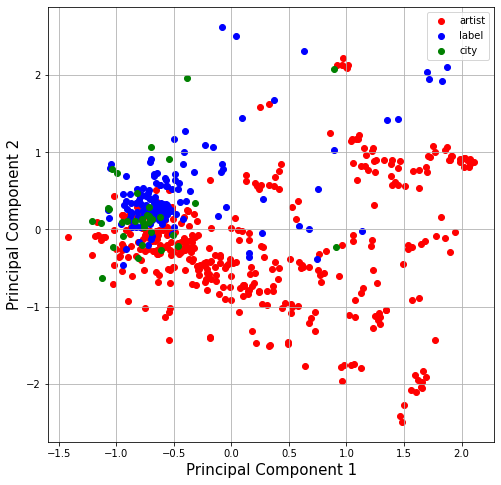

In [10]:
# Create a visualization

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(dfX)
principalDf = pd.DataFrame(data = pca_result
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, dfY], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

targets = ['artist','label','city']
colors = ['r', 'b','g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color)
ax.legend(targets)
ax.grid()